100%|██████████| 7500/7500 [00:14<00:00, 531.35it/s]


253
['acc_x_fftA_0', 'acc_x_fftA_1', 'acc_x_fftA_2', 'acc_x_fftA_3', 'acc_x_fftA_4', 'acc_x_fftP_0', 'acc_x_fftP_1', 'acc_x_fftP_2', 'acc_x_fftP_3', 'acc_x_fftP_4', 'acc_x_psdA_0', 'acc_x_psdA_1', 'acc_x_psdA_2', 'acc_x_psdA_3', 'acc_x_psdA_4', 'acc_x_psdP_0', 'acc_x_psdP_1', 'acc_x_psdP_2', 'acc_x_psdP_3', 'acc_x_psdP_4', 'acc_y_fftA_0', 'acc_y_fftA_1', 'acc_y_fftA_2', 'acc_y_fftA_3', 'acc_y_fftA_4', 'acc_y_fftP_0', 'acc_y_fftP_1', 'acc_y_fftP_2', 'acc_y_fftP_3', 'acc_y_fftP_4', 'acc_y_psdA_0', 'acc_y_psdA_1', 'acc_y_psdA_2', 'acc_y_psdA_3', 'acc_y_psdA_4', 'acc_y_psdP_0', 'acc_y_psdP_1', 'acc_y_psdP_2', 'acc_y_psdP_3', 'acc_y_psdP_4', 'acc_z_fftA_0', 'acc_z_fftA_1', 'acc_z_fftA_2', 'acc_z_fftA_3', 'acc_z_fftA_4', 'acc_z_fftP_0', 'acc_z_fftP_1', 'acc_z_fftP_2', 'acc_z_fftP_3', 'acc_z_fftP_4', 'acc_z_psdA_0', 'acc_z_psdA_1', 'acc_z_psdA_2', 'acc_z_psdA_3', 'acc_z_psdA_4', 'acc_z_psdP_0', 'acc_z_psdP_1', 'acc_z_psdP_2', 'acc_z_psdP_3', 'acc_z_psdP_4', 'acc_xg_fftA_0', 'acc_xg_fftA_1', '

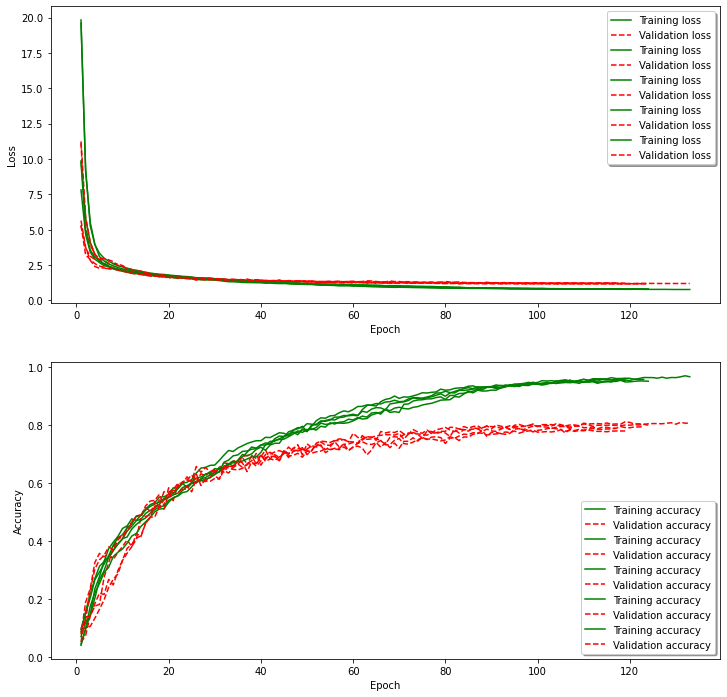

In [1]:
#  不把噪声concatenate, 加入标签平滑, 加上统计特征
import pandas as pd
import numpy as np
import random
from scipy.signal import resample
from tqdm import tqdm
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import *

txdir='/content/drive/My Drive/xwbank2020/'
os.chdir(txdir)
df_train = pd.read_csv('sensor_train.csv')
df_test = pd.read_csv('sensor_test.csv')
sub = pd.read_csv('./Submit/submit.csv')
y = df_train.groupby('fragment_id')['behavior_id'].min()

def smooth_cols(group):
    cols = ['acc_x','acc_y','acc_z','acc_xg','acc_yg','acc_zg']
    for col in cols:
        Max=group[col].quantile(q=0.995)
        Min=group[col].quantile(q=0.005)
        group.loc[group[col]>Max,col]=Max
        group.loc[group[col]<Min,col]=Min
    return group

def z_score(x):
    x_ave=np.average(x,axis = 0)
    x_std=np.std(x,axis = 0)
    z=(x-x_ave)/x_std
    return z,x_ave,x_std
    

df_train['acc'] = (df_train['acc_x'] ** 2 + df_train['acc_y'] ** 2 + df_train['acc_z'] ** 2) ** 0.5
df_train['accg'] = (df_train['acc_xg'] ** 2 + df_train['acc_yg'] ** 2 + df_train['acc_zg'] ** 2) ** 0.5
df_train['xy'] = (df_train['acc_x'] ** 2 + df_train['acc_y'] ** 2) ** 0.5
df_train['xy_g'] = (df_train['acc_xg'] ** 2 + df_train['acc_yg'] ** 2) ** 0.5


df_test['acc'] = (df_test['acc_x'] ** 2 + df_test['acc_y'] ** 2 + df_test['acc_z'] ** 2) ** 0.5
df_test['accg'] = (df_test['acc_xg'] ** 2 + df_test['acc_yg'] ** 2 + df_test['acc_zg'] ** 2) ** 0.5
df_test['xy'] = (df_test['acc_x'] ** 2 + df_test['acc_y'] ** 2) ** 0.5
df_test['xy_g'] = (df_test['acc_xg'] ** 2 + df_test['acc_yg'] ** 2) ** 0.5

x=np.zeros((7292*60,10))
for i in tqdm(range(7292)):
    temp=df_train[df_train.fragment_id==i][:60]
    x[i*60:i*60+60,:]=resample(temp.drop(['fragment_id','time_point','behavior_id'],axis=1),60,np.array(temp.time_point))[0]
train_data=z_score(x)[0].reshape([7292,60,10])
lables=df_train.groupby('fragment_id')['behavior_id'].min()

x1=np.zeros((7500*60,10))
for i in tqdm(range(7500)):
    temp=df_test[df_test.fragment_id==i][:60]
    x1[i*60:i*60+60,:]=resample(temp.drop(['fragment_id','time_point'],axis=1),60,np.array(temp.time_point))[0]
test_data=((x1-z_score(x)[1])/z_score(x)[2]).reshape([7500,60,10])


# 使用统计特征
df_tr_te = pd.read_pickle("./Pickel/df_fea1.pkl")
label_feat = 'behavior_id'
train_df = df_tr_te[((df_tr_te[label_feat].isna()==False) & (df_tr_te[label_feat] >=0))].reset_index(drop=True)
test_df  = df_tr_te[((df_tr_te[label_feat].isna()==True) | (df_tr_te[label_feat] < 0))].reset_index(drop=True)

drop_feat = []
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label_feat] + drop_feat)]
print(len(used_feat))
print(used_feat)


selected_feat = ['fragment_id_acc_yg_max',
 'fragment_id_xy_median',
 'fragment_id_acc_yg_min',
 'acc_xg_fftA_0',
 
 'acc_yg_fftA_0',
 'accg_fftA_0',
 'fragment_id_acc_yg_gap',
 'fragment_id_xy_g_max',
 'fragment_id_acc_xg_mean',
 'fragment_id_acc_xg_max',
 'cnt',
 'acc_y_fftA_0',
 'fragment_id_acc_yg_mean',
 'fragment_id_acc_yg_std',
 'fragment_id_acc_yg_median',
 'acc_zg_fftA_0',
 'fragment_id_acc_zg_min',
 'fragment_id_accg_median',
 'fragment_id_acc_xg_min',
 'fragment_id_acc_xg_median']
train_stat = train_df[selected_feat]
test_stat  = test_df[selected_feat]
train_stat = np.array(train_stat.values)
test_stat = np.array(test_stat.values)

kfold = StratifiedKFold(5, shuffle=True)
val_loss = []
val_acc = []
histories = []

def conv_lstm():
    #建立卷积层1
    #model.add(GaussianNoise(input_shape = (60,10),stddev=0.04))
    input = Input(shape=(60, 10))
    hin = Input(shape=(20, ))
    X = Conv1D(filters=256,
                 kernel_size=5,
                 padding='same',
                 activation = 'relu')(input)
    X = BatchNormalization()(X)
    #建立卷积层2
    X = Conv1D(filters=192,
                 kernel_size=5,
                 padding='same',
                 activation = 'relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling1D()(X)
    X = Dropout(0.3)(X)
    #建立卷积层2
    X = Conv1D(filters=128,
                 kernel_size=5,
                 padding='same',
                 activation = 'relu')(X)
    X = MaxPooling1D()(X)
    X = Dropout(0.3)(X)   
    #建立平坦层
    #model.add(GlobalMaxPooling1D())
    #建立隐蔽层
    X = LSTM(64)(X)
    X = BatchNormalization()(X)
    merge = concatenate([X, hin])
    merge = Dropout(0.35)(merge) 
    merge = Dense(32, activation='relu')(merge)####
    y = Dense(19, activation='softmax')(merge)
    
    
    return Model(inputs=[input, hin], outputs=y)
from tensorflow.keras.losses import CategoricalCrossentropy
proba_t = np.zeros((7500, 19))
for fold, (xx, yy) in enumerate(kfold.split(train_data, lables)):
    y_ = to_categorical(lables, num_classes=19)
   
    plateau = ReduceLROnPlateau(monitor="val_accuracy",
                                verbose=0,
                                mode='max',
                                factor=0.6,
                                patience=5)
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                   verbose=0,
                                   mode='max',
                                   patience=14)
    checkpoint = ModelCheckpoint(f'fold{fold}.h5',
                                 monitor='val_accuracy',
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
    model = conv_lstm()
    loss = CategoricalCrossentropy( label_smoothing=0.1)  #平滑度为1
    model.compile(loss=loss,
                  optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    hist = model.fit([train_data[xx], train_stat[xx]], y_[xx],
              epochs=150,
              batch_size=256,
              verbose=2,
              shuffle=True,
              validation_data=([train_data[yy],train_stat[yy]], y_[yy]),
              callbacks=[plateau, early_stopping, checkpoint])
    histories.append(hist)
    val_loss.append(np.min(hist.history['val_loss']))
    val_acc.append(np.max(hist.history['val_accuracy']))
    model.load_weights(f'fold{fold}.h5')
    proba_t += model.predict([test_data,test_stat], verbose=0, batch_size=1024) / 5.
np.savetxt('conv1D_lstm_with_labelsmoothing_plus_statfea_200806.txt',proba_t)
print('log loss:', np.mean(val_loss))
print('val_acc:', np.mean(val_acc))

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
for i in range(5):
    history=histories[i]
    epoch_range = 1 + np.arange(len(history.history['accuracy']))
    plt.plot(epoch_range,history.history['loss'],'g-',label='Training loss')
    plt.plot(epoch_range,history.history['val_loss'],'r--',label='Validation loss')
    plt.legend(loc='best',shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.xlim([0,epochs])


plt.subplot(2,1,2)
for i in range(5):
    history=histories[i]
    epoch_range = 1 + np.arange(len(history.history['accuracy']))
    plt.plot(epoch_range,history.history['accuracy'],'g-',label='Training accuracy')
    plt.plot(epoch_range,history.history['val_accuracy'],'r--',label='Validation accuracy')
    plt.legend(loc='best',shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.xlim([0,epochs])
plt.show()
sub.behavior_id = np.argmax(proba_t, axis=1)
sub.to_csv('conv1D_lstm_with_labelsmoothing_plus_statfea_200806.csv', index=False)

100%|██████████| 7500/7500 [00:13<00:00, 544.41it/s]


253
['acc_x_fftA_0', 'acc_x_fftA_1', 'acc_x_fftA_2', 'acc_x_fftA_3', 'acc_x_fftA_4', 'acc_x_fftP_0', 'acc_x_fftP_1', 'acc_x_fftP_2', 'acc_x_fftP_3', 'acc_x_fftP_4', 'acc_x_psdA_0', 'acc_x_psdA_1', 'acc_x_psdA_2', 'acc_x_psdA_3', 'acc_x_psdA_4', 'acc_x_psdP_0', 'acc_x_psdP_1', 'acc_x_psdP_2', 'acc_x_psdP_3', 'acc_x_psdP_4', 'acc_y_fftA_0', 'acc_y_fftA_1', 'acc_y_fftA_2', 'acc_y_fftA_3', 'acc_y_fftA_4', 'acc_y_fftP_0', 'acc_y_fftP_1', 'acc_y_fftP_2', 'acc_y_fftP_3', 'acc_y_fftP_4', 'acc_y_psdA_0', 'acc_y_psdA_1', 'acc_y_psdA_2', 'acc_y_psdA_3', 'acc_y_psdA_4', 'acc_y_psdP_0', 'acc_y_psdP_1', 'acc_y_psdP_2', 'acc_y_psdP_3', 'acc_y_psdP_4', 'acc_z_fftA_0', 'acc_z_fftA_1', 'acc_z_fftA_2', 'acc_z_fftA_3', 'acc_z_fftA_4', 'acc_z_fftP_0', 'acc_z_fftP_1', 'acc_z_fftP_2', 'acc_z_fftP_3', 'acc_z_fftP_4', 'acc_z_psdA_0', 'acc_z_psdA_1', 'acc_z_psdA_2', 'acc_z_psdA_3', 'acc_z_psdA_4', 'acc_z_psdP_0', 'acc_z_psdP_1', 'acc_z_psdP_2', 'acc_z_psdP_3', 'acc_z_psdP_4', 'acc_xg_fftA_0', 'acc_xg_fftA_1', '

23/23 - 2s - loss: 7.6867 - accuracy: 0.0814 - val_loss: 4.5093 - val_accuracy: 0.0562
Epoch 2/150
23/23 - 1s - loss: 4.6345 - accuracy: 0.1495 - val_loss: 3.3859 - val_accuracy: 0.0932
Epoch 3/150
23/23 - 1s - loss: 3.5722 - accuracy: 0.2068 - val_loss: 2.9755 - val_accuracy: 0.1556
Epoch 4/150
23/23 - 1s - loss: 3.0821 - accuracy: 0.2563 - val_loss: 2.6849 - val_accuracy: 0.2330
Epoch 5/150
23/23 - 1s - loss: 2.7898 - accuracy: 0.2914 - val_loss: 2.5384 - val_accuracy: 0.2975
Epoch 6/150
23/23 - 1s - loss: 2.5732 - accuracy: 0.3278 - val_loss: 2.4064 - val_accuracy: 0.3002
Epoch 7/150
23/23 - 0s - loss: 2.4003 - accuracy: 0.3550 - val_loss: 2.3406 - val_accuracy: 0.2886
Epoch 8/150
23/23 - 1s - loss: 2.2827 - accuracy: 0.3840 - val_loss: 2.2693 - val_accuracy: 0.3331
Epoch 9/150
23/23 - 0s - loss: 2.1816 - accuracy: 0.3991 - val_loss: 2.2122 - val_accuracy: 0.3331
Epoch 10/150
23/23 - 1s - loss: 2.1049 - accuracy: 0.4212 - val_loss: 2.1001 - val_accuracy: 0.3434
Epoch 11/150
23/23 - 

23/23 - 2s - loss: 19.2923 - accuracy: 0.0614 - val_loss: 12.2185 - val_accuracy: 0.0480
Epoch 2/150
23/23 - 1s - loss: 9.1878 - accuracy: 0.1193 - val_loss: 4.4306 - val_accuracy: 0.1508
Epoch 3/150
23/23 - 0s - loss: 5.1318 - accuracy: 0.1714 - val_loss: 3.5520 - val_accuracy: 0.1385
Epoch 4/150
23/23 - 0s - loss: 3.9765 - accuracy: 0.2230 - val_loss: 3.1318 - val_accuracy: 0.1487
Epoch 5/150
23/23 - 1s - loss: 3.3270 - accuracy: 0.2524 - val_loss: 3.0470 - val_accuracy: 0.1905
Epoch 6/150
23/23 - 1s - loss: 3.0454 - accuracy: 0.2736 - val_loss: 2.8243 - val_accuracy: 0.1953
Epoch 7/150
23/23 - 1s - loss: 2.8049 - accuracy: 0.2964 - val_loss: 2.8035 - val_accuracy: 0.2344
Epoch 8/150
23/23 - 0s - loss: 2.5891 - accuracy: 0.3249 - val_loss: 2.7374 - val_accuracy: 0.2296
Epoch 9/150
23/23 - 1s - loss: 2.4521 - accuracy: 0.3499 - val_loss: 2.7307 - val_accuracy: 0.2467
Epoch 10/150
23/23 - 1s - loss: 2.3446 - accuracy: 0.3710 - val_loss: 2.4699 - val_accuracy: 0.2851
Epoch 11/150
23/23 

23/23 - 2s - loss: 8.7155 - accuracy: 0.0926 - val_loss: 5.1617 - val_accuracy: 0.0748
Epoch 2/150
23/23 - 1s - loss: 5.3179 - accuracy: 0.1296 - val_loss: 3.8745 - val_accuracy: 0.1790
Epoch 3/150
23/23 - 1s - loss: 4.1467 - accuracy: 0.1623 - val_loss: 3.2958 - val_accuracy: 0.2147
Epoch 4/150
23/23 - 1s - loss: 3.4294 - accuracy: 0.2149 - val_loss: 2.9609 - val_accuracy: 0.2545
Epoch 5/150
23/23 - 1s - loss: 3.0077 - accuracy: 0.2520 - val_loss: 2.7231 - val_accuracy: 0.2737
Epoch 6/150
23/23 - 1s - loss: 2.7507 - accuracy: 0.2864 - val_loss: 2.4797 - val_accuracy: 0.3258
Epoch 7/150
23/23 - 0s - loss: 2.5368 - accuracy: 0.3269 - val_loss: 2.4182 - val_accuracy: 0.2922
Epoch 8/150
23/23 - 1s - loss: 2.3672 - accuracy: 0.3663 - val_loss: 2.3717 - val_accuracy: 0.3409
Epoch 9/150
23/23 - 0s - loss: 2.2672 - accuracy: 0.3795 - val_loss: 2.2794 - val_accuracy: 0.3388
Epoch 10/150
23/23 - 1s - loss: 2.1574 - accuracy: 0.4133 - val_loss: 2.0844 - val_accuracy: 0.4102
Epoch 11/150
23/23 - 

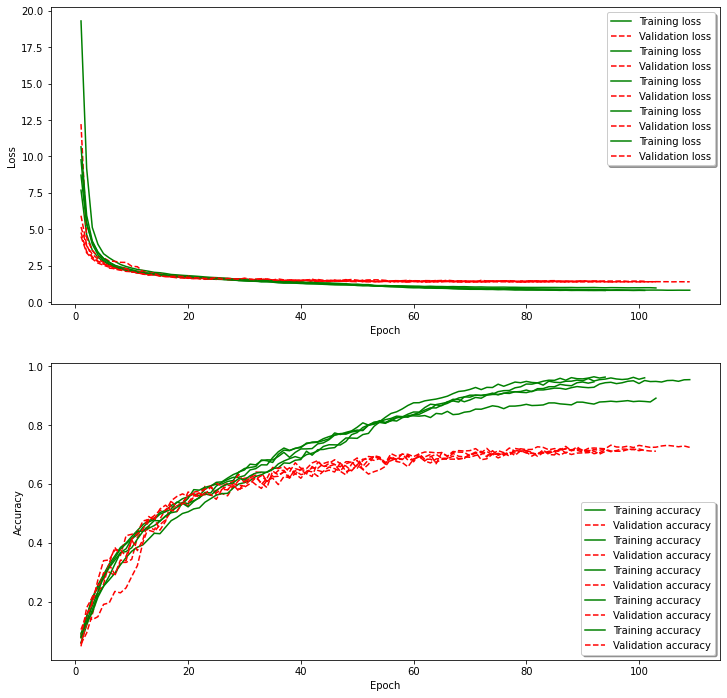

In [11]:
#  根据信噪比加噪声（不concatenate）, 加入标签平滑, 加上统计特征
import pandas as pd
import numpy as np
import random
from scipy.signal import resample
from tqdm import tqdm
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import *



txdir='/content/drive/My Drive/xwbank2020/'
os.chdir(txdir)
df_train = pd.read_csv('sensor_train.csv')
df_test = pd.read_csv('sensor_test.csv')
sub = pd.read_csv('./Submit/submit.csv')
y = df_train.groupby('fragment_id')['behavior_id'].min()

def smooth_cols(group):
    cols = ['acc_x','acc_y','acc_z','acc_xg','acc_yg','acc_zg']
    for col in cols:
        Max=group[col].quantile(q=0.995)
        Min=group[col].quantile(q=0.005)
        group.loc[group[col]>Max,col]=Max
        group.loc[group[col]<Min,col]=Min
    return group

def z_score(x):
    x_ave=np.average(x,axis = 0)
    x_std=np.std(x,axis = 0)
    z=(x-x_ave)/x_std
    return z,x_ave,x_std
    

df_train['acc'] = (df_train['acc_x'] ** 2 + df_train['acc_y'] ** 2 + df_train['acc_z'] ** 2) ** 0.5
df_train['accg'] = (df_train['acc_xg'] ** 2 + df_train['acc_yg'] ** 2 + df_train['acc_zg'] ** 2) ** 0.5
df_train['xy'] = (df_train['acc_x'] ** 2 + df_train['acc_y'] ** 2) ** 0.5
df_train['xy_g'] = (df_train['acc_xg'] ** 2 + df_train['acc_yg'] ** 2) ** 0.5


df_test['acc'] = (df_test['acc_x'] ** 2 + df_test['acc_y'] ** 2 + df_test['acc_z'] ** 2) ** 0.5
df_test['accg'] = (df_test['acc_xg'] ** 2 + df_test['acc_yg'] ** 2 + df_test['acc_zg'] ** 2) ** 0.5
df_test['xy'] = (df_test['acc_x'] ** 2 + df_test['acc_y'] ** 2) ** 0.5
df_test['xy_g'] = (df_test['acc_xg'] ** 2 + df_test['acc_yg'] ** 2) ** 0.5

x=np.zeros((7292*60,10))
for i in tqdm(range(7292)):
    temp=df_train[df_train.fragment_id==i][:60]
    x[i*60:i*60+60,:]=resample(temp.drop(['fragment_id','time_point','behavior_id'],axis=1),60,np.array(temp.time_point))[0]
train_data=z_score(x)[0].reshape([7292,60,10])
lables=df_train.groupby('fragment_id')['behavior_id'].min()

x1=np.zeros((7500*60,10))
for i in tqdm(range(7500)):
    temp=df_test[df_test.fragment_id==i][:60]
    x1[i*60:i*60+60,:]=resample(temp.drop(['fragment_id','time_point'],axis=1),60,np.array(temp.time_point))[0]
test_data=((x1-z_score(x)[1])/z_score(x)[2]).reshape([7500,60,10])


# 使用统计特征
df_tr_te = pd.read_pickle("./Pickel/df_fea1.pkl")
label_feat = 'behavior_id'
train_df = df_tr_te[((df_tr_te[label_feat].isna()==False) & (df_tr_te[label_feat] >=0))].reset_index(drop=True)
test_df  = df_tr_te[((df_tr_te[label_feat].isna()==True) | (df_tr_te[label_feat] < 0))].reset_index(drop=True)

drop_feat = []
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label_feat] + drop_feat)]
print(len(used_feat))
print(used_feat)


selected_feat = ['fragment_id_acc_yg_max',
 'fragment_id_xy_median',
 'fragment_id_acc_yg_min',
 'acc_xg_fftA_0',
 
 'acc_yg_fftA_0',
 'accg_fftA_0',
 'fragment_id_acc_yg_gap',
 'fragment_id_xy_g_max',
 'fragment_id_acc_xg_mean',
 'fragment_id_acc_xg_max',
 'cnt',
 'acc_y_fftA_0',
 'fragment_id_acc_yg_mean',
 'fragment_id_acc_yg_std',
 'fragment_id_acc_yg_median',
 'acc_zg_fftA_0',
 'fragment_id_acc_zg_min',
 'fragment_id_accg_median',
 'fragment_id_acc_xg_min',
 'fragment_id_acc_xg_median']
train_stat = train_df[selected_feat]
test_stat  = test_df[selected_feat]
train_stat = np.array(train_stat.values)
test_stat = np.array(test_stat.values)


# add_noise
def jitter(x, snr_db):
    """
    根据信噪比添加噪声
    :param x:
    :param snr_db:
    :return:
    """
    # 随机选择信噪比
    assert isinstance(snr_db, list)
    snr_db_low = snr_db[0]
    snr_db_up = snr_db[1]
    snr_db = np.random.randint(snr_db_low, snr_db_up, (1,))[0]

    snr = 10 ** (snr_db / 10)
    Xp = np.sum(x ** 2, axis=0, keepdims=True) / x.shape[0]  # 计算信号功率
    Np = Xp / snr  # 计算噪声功率
    n = np.random.normal(size=x.shape, scale=np.sqrt(Np), loc=0.0)  # 计算噪声
    xn = x + n
    return xn
    
train_data_ = jitter(train_data, [5,15])
train_stat_ = jitter(train_stat, [5,15])
test_data_ = jitter(test_data, [5,15])
test_stat_ = jitter(test_stat, [5,15])



kfold = StratifiedKFold(5, shuffle=True)
val_loss = []
val_acc = []
histories = []


def conv_lstm():
    #建立卷积层1
    #model.add(GaussianNoise(input_shape = (60,10),stddev=0.04))
    input = Input(shape=(60, 10))
    hin = Input(shape=(20, ))
    X = Conv1D(filters=256,
                 kernel_size=5,
                 padding='same',
                 activation = 'relu')(input)
    X = BatchNormalization()(X)
    #建立卷积层2
    X = Conv1D(filters=192,
                 kernel_size=5,
                 padding='same',
                 activation = 'relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling1D()(X)
    X = Dropout(0.3)(X)
    #建立卷积层2
    X = Conv1D(filters=128,
                 kernel_size=5,
                 padding='same',
                 activation = 'relu')(X)
    X = MaxPooling1D()(X)
    X = Dropout(0.3)(X)   
    #建立平坦层
    #model.add(GlobalMaxPooling1D())
    #建立隐蔽层
    X = LSTM(64)(X)
    X = BatchNormalization()(X)
    merge = concatenate([X, hin])
    merge = Dropout(0.35)(merge) 
    merge = Dense(32, activation='relu')(merge)####
    y = Dense(19, activation='softmax')(merge)
    return Model(inputs=[input, hin], outputs=y)

from tensorflow.keras.losses import CategoricalCrossentropy
proba_t = np.zeros((7500, 19))
for fold, (xx, yy) in enumerate(kfold.split(train_data, lables)):
    y_ = to_categorical(lables, num_classes=19)
   
    plateau = ReduceLROnPlateau(monitor="val_accuracy",
                                verbose=0,
                                mode='max',
                                factor=0.6,
                                patience=5)
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                   verbose=0,
                                   mode='max',
                                   patience=14)
    checkpoint = ModelCheckpoint(f'fold{fold}.h5',
                                 monitor='val_accuracy',
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
    model = conv_lstm()
    loss = CategoricalCrossentropy( label_smoothing=0.1)  #平滑度为1
    model.compile(loss=loss,
                  optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    hist = model.fit([train_data_[xx], train_stat_[xx]], y_[xx],
              epochs=150,
              batch_size=256,
              verbose=2,
              shuffle=True,
              validation_data=([train_data[yy],train_stat[yy]], y_[yy]),
              callbacks=[plateau, early_stopping, checkpoint])
    histories.append(hist)
    val_loss.append(np.min(hist.history['val_loss']))
    val_acc.append(np.max(hist.history['val_accuracy']))
    model.load_weights(f'fold{fold}.h5')
    proba_t += model.predict([test_data,test_stat], verbose=0, batch_size=1024) / 5.
np.savetxt('conv1D_lstm_with_labelsmoothing_plus_statfea_200806_addnoise.txt',proba_t)
print('log loss:', np.mean(val_loss))
print('val_acc:', np.mean(val_acc))

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
for i in range(5):
    history=histories[i]
    epoch_range = 1 + np.arange(len(history.history['accuracy']))
    plt.plot(epoch_range,history.history['loss'],'g-',label='Training loss')
    plt.plot(epoch_range,history.history['val_loss'],'r--',label='Validation loss')
    plt.legend(loc='best',shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.xlim([0,epochs])


plt.subplot(2,1,2)
for i in range(5):
    history=histories[i]
    epoch_range = 1 + np.arange(len(history.history['accuracy']))
    plt.plot(epoch_range,history.history['accuracy'],'g-',label='Training accuracy')
    plt.plot(epoch_range,history.history['val_accuracy'],'r--',label='Validation accuracy')
    plt.legend(loc='best',shadow=True)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.xlim([0,epochs])
plt.show()
